In [ ]:
!pip install kaggle
!pip install IPython
!pip install seaborn
!pip install plotly
!pip install -U scikit-learn scipy matplotlib
!pip install keras

In [15]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [16]:
!cp /content/kaggle.json ~/.kaggle/

In [17]:
! chmod 600 ~/.kaggle/kaggle.json


In [18]:
! kaggle datasets download -d odins0n/ucf-crime-dataset

100% 11.0G/11.0G [04:44<00:00, 45.6MB/s]
100% 11.0G/11.0G [04:44<00:00, 41.5MB/s]


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')  

In [ ]:
! unzip ucf-crime-dataset.zip

In [21]:
train_dir="/content/Train"
test_dir="/content/Test"

SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 128
EPOCHS = 5
LR = 0.00003

In [22]:
crime_types=os.listdir(train_dir)
n=len(crime_types)
print("Number of Crime Categories : ",n)

Number of Crime Categories :  14


In [23]:
crimes={}
train=test=0
for clss in crime_types:
  num=len(os.listdir(os.path.join(train_dir,clss)))
  train+=num
  test+=len(os.listdir(os.path.join(test_dir,clss)))

  crimes[clss]=num

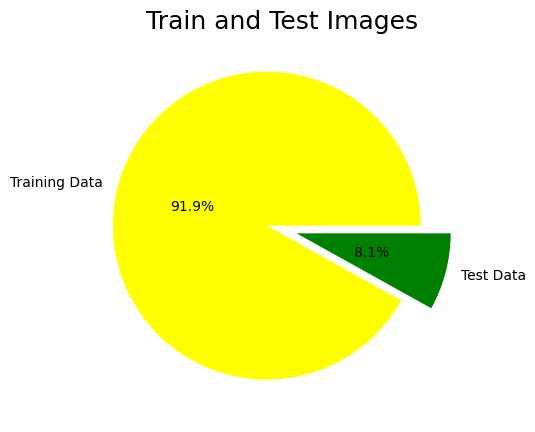

In [24]:
plt.figure(figsize=(8,5))
plt.pie(x=np.array([train,test]),autopct="%.1f%%", explode=[0.1,0.1], labels=["Training Data", "Test Data"], pctdistance=0.5, colors=['yellow','green'])
plt.title("Train and Test Images", fontsize=18);

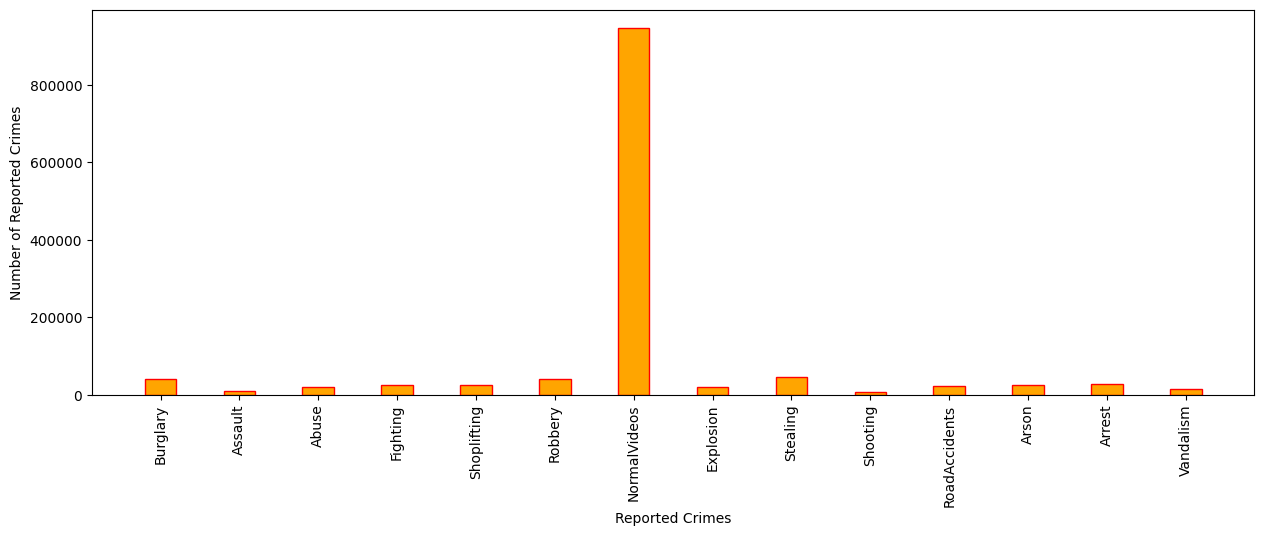

In [25]:
plt.figure(figsize=(15,5))
plt.bar(list(crimes.keys()),list(crimes.values()),width=0.4, align="center", edgecolor=['red'], color=['orange'])
plt.xticks(rotation=90)

plt.xlabel("Reported Crimes")
plt.ylabel("Number of Reported Crimes")
plt.show()

In [26]:
IMG_SHAPE=(IMG_WIDTH,IMG_HEIGHT)

In [27]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.


In [28]:
val_set=image_dataset_from_directory( 
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE, 
    image_size=IMG_SHAPE, 
    shuffle=True, 
    seed=SEED, 
    validation_split=0.2, 
    subset="validation"
)

Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.


In [29]:
test_set=image_dataset_from_directory(
     test_dir,
     label_mode="categorical",
     image_size=IMG_SHAPE,
     shuffle=False,
     class_names=None,
     batch_size=BATCH_SIZE,
     seed=SEED
)

Found 111308 files belonging to 14 classes.


In [30]:
INPUT_SHAPE=(64,64,3)

In [31]:
def transfer_learning():
  base_model=DenseNet121(include_top=False,
                         input_shape=INPUT_SHAPE,
                         weights="imagenet")

  thr=14
  
  for layers in base_model.layers[:thr]:
    layers.trainable=False
  for layers in base_model.layers[thr:]: 
    layers.trainable=False

    return base_model

In [32]:
def create_model(): 
  model=Sequential()

  base_model=transfer_learning() 
  model.add(base_model)

  model.add(GlobalAveragePooling2D())
  
  model.add(Dense (256, activation="relu")) 
  model.add(Dropout (0.2))

  model.add(Dense (512, activation="relu")) 
  model.add(Dropout (0.2))

  model.add(Dense (1024, activation="relu"))

  model.add(Dense (n, activation="softmax"))
  
  model.summary()
  return model

In [33]:
model=create_model()

model.compile(optimizer="adam",
            loss='categorical_crossentropy',
            metrics = ['accuracy'])

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 2, 2, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0 

In [34]:
history = model.fit(x=train_set,validation_data=val_set, epochs=EPOCHS)

Epoch 1/5
7915/7915 [==============================] - 1729s 207ms/step - loss: 0.0970 - accuracy: 0.9741 - val_loss: 0.1867 - val_accuracy: 0.9640
Epoch 2/5
7915/7915 [==============================] - 1625s 205ms/step - loss: 0.0279 - accuracy: 0.9931 - val_loss: 0.0464 - val_accuracy: 0.9874
Epoch 3/5
7915/7915 [==============================] - 1627s 205ms/step - loss: 0.0202 - accuracy: 0.9951 - val_loss: 0.0158 - val_accuracy: 0.9962
Epoch 4/5
7915/7915 [==============================] - 1594s 201ms/step - loss: 0.0161 - accuracy: 0.9961 - val_loss: 0.0119 - val_accuracy: 0.9968
Epoch 5/5
7915/7915 [==============================] - 1593s 201ms/step - loss: 0.0151 - accuracy: 0.9964 - val_loss: 0.0084 - val_accuracy: 0.9977


In [35]:
model.save('crime.h5')